<a href="https://colab.research.google.com/github/atharvanaik10/cs498-css/blob/main/cs498_rp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q ydata-profiling
!pip install -q matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.9/357.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 20.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.26.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.1 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

# Creating the Dataset

This is a dataset of factors believed to influence homelessness across communities. The dictionary is included in the data folder in Google Drive.

Tasks
1. Find dataset for all counties
2. Write a script based on API calls for each county to download the excel sheets for 2010-2017

Source: https://www.huduser.gov/portal/datasets/hpmd.html?q=datasets%2Fhpmd.html

In [3]:
data_filepath = 'https://raw.githubusercontent.com/atharvanaik10/cs498-css/main/data/05b_analysis_file_update.csv'
df_full = pd.read_csv(data_filepath)

df_il = df_full[df_full['cocnumber'].str.contains('IL')]
df_il['pit_tot_pit_hud'] = (df_il['pit_tot_shelt_pit_hud'] + df_il['pit_tot_unshelt_pit_hud'] + df_il['pit_tot_hless_pit_hud'])
df_il

<ipython-input-3-57652406b205>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_il['pit_tot_pit_hud'] = (df_il['pit_tot_shelt_pit_hud'] + df_il['pit_tot_unshelt_pit_hud'] + df_il['pit_tot_hless_pit_hud'])


,year,cocnumber,pit_tot_shelt_pit_hud,pit_tot_unshelt_pit_hud,pit_tot_hless_pit_hud,pit_ind_shelt_pit_hud,pit_ind_unshelt_pit_hud,pit_ind_hless_pit_hud,pit_perfam_shelt_pit_hud,pit_perfam_unshelt_pit_hud,...,sub_high_cost_homeval75,sub_high_rent_share75,tight_high_cost_rental_mkt,sub_tight_high_cost_rent,sub_west_coast_all_urb,sub_west_census,major_city,suburban,rural,pit_tot_pit_hud
840,2010,IL-500,211.0,1.0,212.0,123.0,1.0,124.0,88.0,0.0,...,1,1,3,1,0,0,0,1,0,424.0
841,2011,IL-500,179.0,3.0,182.0,110.0,3.0,113.0,69.0,0.0,...,0,0,0,0,0,0,0,1,0,364.0
842,2012,IL-500,193.0,3.0,196.0,120.0,3.0,123.0,73.0,0.0,...,1,1,3,1,0,0,0,1,0,392.0
843,2013,IL-500,180.0,5.0,185.0,106.0,5.0,111.0,74.0,0.0,...,0,0,0,0,0,0,0,1,0,370.0
844,2014,IL-500,161.0,5.0,166.0,103.0,5.0,108.0,58.0,0.0,...,1,1,3,1,0,0,0,1,0,332.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,2013,IL-520,263.0,75.0,338.0,121.0,39.0,160.0,142.0,36.0,...,0,0,0,0,0,0,0,0,1,676.0
988,2014,IL-520,279.0,46.0,325.0,142.0,33.0,175.0,137.0,13.0,...,1,1,3,1,0,0,0,0,1,650.0
989,2015,IL-520,316.0,30.0,346.0,166.0,26.0,192.0,150.0,4.0,...,0,0,0,0,0,0,0,0,1,692.0
990,2016,IL-520,332.0,19.0,351.0,159.0,16.0,175.0,173.0,3.0,...,1,1,3,1,0,0,0,0,1,702.0


Since this dataset does not contain any health/healthcare data, we append a health dataset from Illinois below.

The first step is to create a master health rankings dataset for all the counties in Illinois for all the years.

In [4]:
# Load yearly datasets
years = range(2010, 2018)
file_path_template = 'https://raw.githubusercontent.com/atharvanaik10/cs498-css/main/data/health_data/{}_county_ranking.xls'# Assuming the files are named like 'health_data_2010.xlsx', etc.

# Initialize an empty list to store each year's DataFrame
health_dfs = []

for year in years:
    file_path = file_path_template.format(year)
    # Load the "Subrankings" sheet from the current year's file
    df = pd.read_excel(file_path, sheet_name='Outcomes & Factors SubRankings', header=[0,1])
    # Create new column names by combining the top-level category with the subcolumn name
    df.columns = [f'{col[0]}_{col[1]}'.replace(' ', '_') if col[1] else col[0].replace(' ', '_') for col in df.columns]
    # Add a 'year' column to the DataFrame
    df['year'] = year
    # Append the DataFrame to the list
    health_dfs.append(df)

In [5]:
# Combine into master health ranking dataset and drop irrelevant columns
df_health_rankings = pd.concat(health_dfs, ignore_index=True)
df_health_rankings.drop(0, axis='index', inplace=True)
df_health_rankings.drop(['Unnamed:_0_level_0_FIPS', 'Unnamed:_1_level_0_State'], axis=1, inplace=True)
df_health_rankings.rename(columns={'Unnamed:_2_level_0_County' : 'county'}, inplace=True)

# We note that the "Mortality" column was changed to "Length of Life" and
# the "Morbidity" column was changed to "Quality of Life". Hence, we combine
# these two columns into one.
df_health_rankings['Mortality_Z-Score'] = df_health_rankings['Mortality_Z-Score'].combine_first(df_health_rankings['Length_of_Life_Z-Score'])
df_health_rankings['Mortality_Rank'] = df_health_rankings['Mortality_Rank'].combine_first(df_health_rankings['Length_of_Life_Rank'])
df_health_rankings['Morbidity_Z-Score'] = df_health_rankings['Morbidity_Z-Score'].combine_first(df_health_rankings['Quality_of_Life_Z-Score'])
df_health_rankings['Morbidity_Rank'] = df_health_rankings['Morbidity_Rank'].combine_first(df_health_rankings['Quality_of_Life_Rank'])
df_health_rankings.drop(['Length_of_Life_Z-Score', 'Length_of_Life_Rank', 'Quality_of_Life_Z-Score', 'Quality_of_Life_Rank'], axis=1, inplace=True)

df_health_rankings

,county,Mortality_Z-Score,Mortality_Rank,Morbidity_Z-Score,Morbidity_Rank,Health_Behaviors_Z-Score,Health_Behaviors_Rank,Clinical_Care_Z-Score,Clinical_Care_Rank,Social_&_Economic_Factors_Z-Score,Social_&_Economic_Factors_Rank,Physical_Environment_Z-Score,Physical_Environment_Rank,year
1,Adams,-0.315922,26.0,0.018905,55.0,-0.177479,9.0,-0.128418,8.0,-0.222109,18.0,-0.003727,53.0,2010
2,Alexander,1.449328,99.0,0.600000,100.0,0.324788,99.0,-0.132972,6.0,0.814184,101.0,0.070877,94.0,2010
3,Bond,-0.218783,36.0,0.296697,81.0,0.062052,74.0,0.005012,60.0,-0.082260,42.0,-0.046851,13.0,2010
4,Boone,-0.539522,11.0,0.075576,63.0,-0.248704,4.0,0.005551,61.0,0.242444,82.0,-0.005828,50.0,2010
5,Brown,-0.282644,30.0,-0.197342,27.0,0.073038,80.0,-0.052093,36.0,-0.222639,16.0,-0.067829,2.0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,Whiteside,-0.101659,44.0,-0.395511,15.0,-0.095026,24.0,-0.070668,27.0,-0.037313,44.0,-0.024960,40.0,2017
820,Will,-0.700882,8.0,-0.180036,37.0,-0.150657,11.0,-0.022934,38.0,-0.234465,17.0,0.102365,98.0,2017
821,Williamson,0.323895,81.0,0.073420,60.0,0.093817,78.0,-0.005888,45.0,0.076363,69.0,0.015021,67.0,2017
822,Winnebago,0.247607,73.0,0.421506,91.0,0.210368,96.0,-0.001822,48.0,0.409720,96.0,0.060289,90.0,2017


Now we have two datasets, one for homelessness and other economic factors that is split by CoC, and one for health rankings that is split by county. Thankfully in most cases, CoC boundaries map neatly to existing county boundaries. We create a CoC to county mapping below and merge our datasets into a master dataset that is separated by CoC that includes the average health factors of all the counties in that CoC.

In [6]:
coc_to_county = {
    'IL-500' : ['McHenry'],
    'IL-501' : ['Winnebago', 'Boone'],
    'IL-502' : ['Lake'],
    'IL-503' : ['Champaign'],
    'IL-504' : ['Madison'],
    'IL-506' : ['Will', 'Kendall', 'Grundy'],
    'IL-507' : ['Peoria', 'Fulton', 'Tazewell', 'Woodford'],
    'IL-508' : ['McHenry'],
    'IL-509' : ['DeKalb'],
    'IL-510' : ['Cook'],
    'IL-511' : ['Cook'],
    'IL-512' : ['DeWitt', 'Ford', 'Iroquois', 'Kankakee', 'Livingston', 'Logan',
                'Mason', 'Menard', 'McLean', 'Piatt', 'Vermilion'],
    'IL-513' : ['Sangamon'],
    'IL-514' : ['DuPage'],
    'IL-515' : ['Calhoun', 'Christian', 'Clark', 'Clay', 'Coles', 'Crawford',
                'Cumberland', 'Douglas', 'Edgar', 'Effingham', 'Fayette',
                'Greene', 'Jasper', 'Jersey', 'Macoupin', 'Montgomery',
                'Moultrie', 'Shelby'],
    'IL-516' : ['Macon'],
    'IL-517' : ['Kane'],
    'IL-518' : ['Bureau', 'Carroll', 'Jo Daviess', 'Henry', 'Knox', 'LaSalle',
                'Lee', 'Marshall', 'Mercer', 'Ogle', 'Putnam', 'Rock Island',
                'Stark', 'Stephenson', 'Whiteside'],
    'IL-519' : ['Adams', 'Brown', 'Cass', 'Hancock', 'Henderson', 'McDonough',
                'Morgan', 'Pike', 'Schuyler', 'Scott', 'Warren'],
    'IL-520' : ['Alexander', 'Bond', 'Clinton', 'Edwards', 'Franklin',
                'Gallatin', 'Hamilton', 'Hardin', 'Jackson', 'Jefferson',
                'Johnson', 'Lawrence', 'Marion', 'Massac', 'Monroe', 'Perry',
                'Pope', 'Pulaski', 'Randolph', 'Richland', 'Saline', 'Union',
                'Wabash', 'Washington', 'Wayne', 'White', 'Williamson'],
}

In [7]:
# Calculate mean stats by CoC
coc_avgs = []
for coc, counties in coc_to_county.items():
  subset = df_health_rankings[df_health_rankings['county'].isin(counties)]
  avg_stats = subset.groupby('year').mean(numeric_only=True).reset_index()
  avg_stats['cocnumber'] = coc
  coc_avgs.append(avg_stats)

# combine all averages
coc_avg_df = pd.concat(coc_avgs, ignore_index=True)

df = pd.merge(df_il, coc_avg_df, on=['cocnumber', 'year'], how='left')
df

,year,cocnumber,pit_tot_shelt_pit_hud,pit_tot_unshelt_pit_hud,pit_tot_hless_pit_hud,pit_ind_shelt_pit_hud,pit_ind_unshelt_pit_hud,pit_ind_hless_pit_hud,pit_perfam_shelt_pit_hud,pit_perfam_unshelt_pit_hud,...,Morbidity_Z-Score,Morbidity_Rank,Health_Behaviors_Z-Score,Health_Behaviors_Rank,Clinical_Care_Z-Score,Clinical_Care_Rank,Social_&_Economic_Factors_Z-Score,Social_&_Economic_Factors_Rank,Physical_Environment_Z-Score,Physical_Environment_Rank
0,2010,IL-500,211.0,1.0,212.0,123.0,1.0,124.0,88.0,0.0,...,-0.262275,19.000000,-0.077647,29.000000,-0.065311,27.000000,-0.431845,5.000000,0.009561,70.000000
1,2011,IL-500,179.0,3.0,182.0,110.0,3.0,113.0,69.0,0.0,...,-0.319520,16.000000,-0.116947,16.000000,-0.011183,50.000000,-0.368764,7.000000,-0.050696,11.000000
2,2012,IL-500,193.0,3.0,196.0,120.0,3.0,123.0,73.0,0.0,...,-0.274948,20.000000,-0.264598,4.000000,-0.067671,29.000000,-0.398543,7.000000,0.002239,60.000000
3,2013,IL-500,180.0,5.0,185.0,106.0,5.0,111.0,74.0,0.0,...,-0.097183,42.000000,-0.245293,5.000000,-0.115609,17.000000,-0.356753,7.000000,-0.023845,25.000000
4,2014,IL-500,161.0,5.0,166.0,103.0,5.0,108.0,58.0,0.0,...,-0.137073,35.000000,-0.199592,6.000000,-0.091232,23.000000,-0.412663,6.000000,0.063221,97.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,2013,IL-520,263.0,75.0,338.0,121.0,39.0,160.0,142.0,36.0,...,0.123743,62.481481,0.037166,61.037037,0.051943,66.259259,0.108449,64.962963,0.033150,72.925926
148,2014,IL-520,279.0,46.0,325.0,142.0,33.0,175.0,137.0,13.0,...,0.136255,65.777778,0.053163,63.074074,0.060579,66.814815,0.102835,63.222222,0.020539,67.703704
149,2015,IL-520,316.0,30.0,346.0,166.0,26.0,192.0,150.0,4.0,...,0.157189,67.777778,0.061233,66.370370,0.068371,69.518519,0.111391,66.000000,0.022888,67.814815
150,2016,IL-520,332.0,19.0,351.0,159.0,16.0,175.0,173.0,3.0,...,0.211328,67.185185,0.083181,67.925926,0.065990,70.370370,0.110339,64.185185,0.013939,60.222222


# Data Exploration

### Using `ydata-profiling`

In [ ]:
profile = ProfileReport(df, title="Time-series Report", tsmode=True, sortby='year')
profile.to_file("df_report.html")

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:354: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ydata_profiling/model/pandas/describe_timeseries_pandas.py:95: RuntimeWarning: divide by zero encountered in log10
  ampl = 10 * np.log10(data_psd[pos_freq_ix])
/usr/local/lib/python3.10/dist-packages/ydata_profiling/model/correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'IL-500'')
  warnings.warn(


### Manual exploration

Text(0.5, 1.0, 'Ratio of Sheltered Population per CoC')

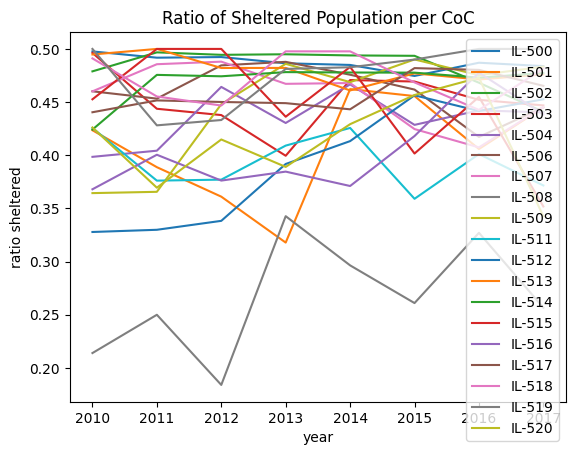

In [ ]:
coc_numbers = ['IL-500',
 'IL-501',
 'IL-502',
 'IL-503',
 'IL-504',
 'IL-506',
 'IL-507',
 'IL-508',
 'IL-509',
 'IL-511',
 'IL-512',
 'IL-513',
 'IL-514',
 'IL-515',
 'IL-516',
 'IL-517',
 'IL-518',
 'IL-519',
 'IL-520']

# data visualization for the total sheltered population per county in Illinois
for i in range(len(coc_numbers)):
  df_co = df_il[df_il['cocnumber']== coc_numbers[i]]
  plt.plot(df_co['year'],df_co['pit_tot_shelt_pit_hud'] / df_co['pit_tot_pit_hud'])
plt.legend(coc_numbers);
plt.ylabel('ratio sheltered')
plt.xlabel('year')
plt.title('Ratio of Sheltered Population per CoC')

Text(0.5, 1.0, 'Ratio of Unsheltered Population per CoC')

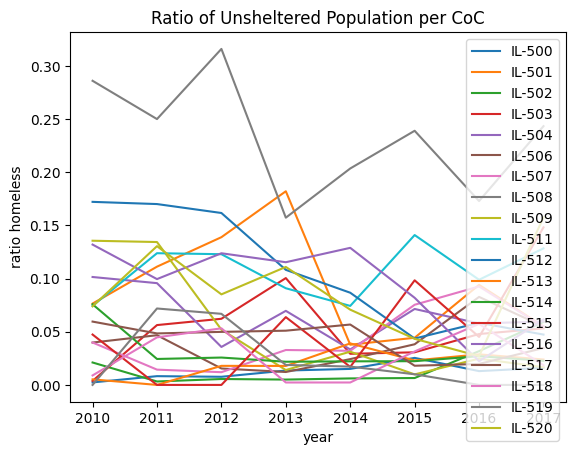

In [ ]:
# data visualization of the ratio of total population that is unsheltered per county in Illinois
for i in range(len(coc_numbers)):
  df_co = df_il[df_il['cocnumber']== coc_numbers[i]]
  plt.plot(df_co['year'],df_co['pit_tot_unshelt_pit_hud'] / df_co['pit_tot_pit_hud'])
plt.legend(coc_numbers);
plt.ylabel('ratio homeless')
plt.xlabel('year')
plt.title('Ratio of Unsheltered Population per CoC')

Text(0.5, 1.0, 'Ratio of Homeless Population per CoC')

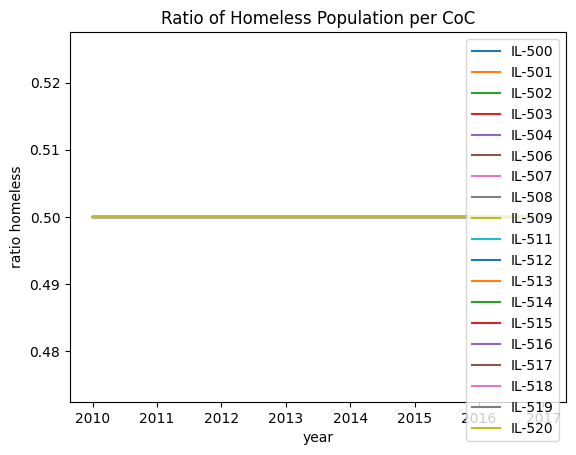

In [ ]:
# data visualization of the ratio of total population that is homeless per county in Illinois
for i in range(len(coc_numbers)):
  df_co = df_il[df_il['cocnumber']== coc_numbers[i]]
  plt.plot(df_co['year'],df_co['pit_tot_hless_pit_hud'] / df_co['pit_tot_pit_hud'])
plt.legend(coc_numbers);
plt.ylabel('ratio homeless')
plt.xlabel('year')
plt.title('Ratio of Homeless Population per CoC')

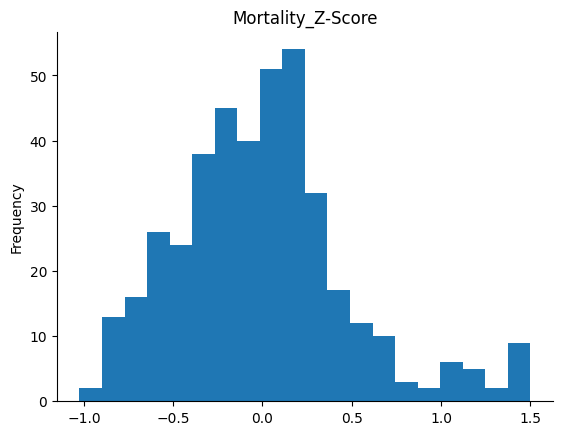

In [ ]:
# @title Mortality_Z-Score

from matplotlib import pyplot as plt
df_health_rankings['Mortality_Z-Score'].plot(kind='hist', bins=20, title='Mortality_Z-Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

Text(0.5, 1.0, 'Mortality_Z-Score vs Mortality_Rank')

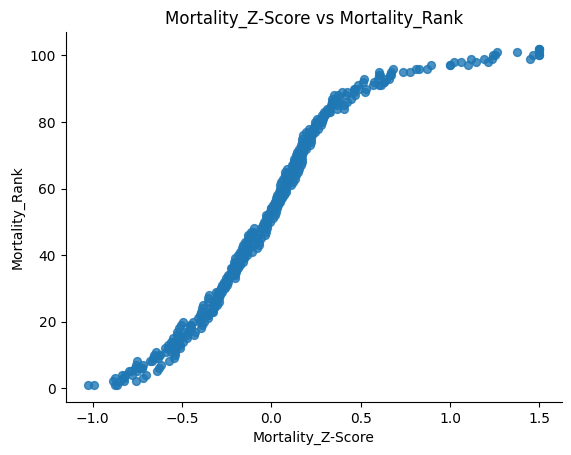

In [ ]:
# @title Mortality_Z-Score vs Mortality_Rank

from matplotlib import pyplot as plt
df_health_rankings.plot(kind='scatter', x='Mortality_Z-Score', y='Mortality_Rank', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title("Mortality_Z-Score vs Mortality_Rank")

Now that we have the master dataset, we create a mapping from counties to CoCs and append by average ranking and average z-score by the counties in each CoC. (TODO).